# Поиск дубликатов новостей

Главная идея алгоритма - поиск полных дублей статей по заголовкам, потом проверка этих дублей косинусным расстоянием по векторам, полученным из текста статей. И добавление перечня дублей, основываясь на статистических данных косинусного расстояния.

### Оглавление: <a id="toc"></a>

1. [Получение данных](#1)
2. [Обогащение  и исследование данных](#2)
3. [Построение Embedings](#3)
4. [Поиск дубля на примере одной статьи](#4)
5. [Общий вывод](#5)


## Получение данных   <a id="1"></a>

#### Импорт библиотек

In [1]:
from mysql.connector import connect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
#git clone https://github.com/nmslib/hnswlib.git

import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk

from IPython.display import display
from datetime import datetime 
import multiprocessing as mp
import string

from datetime import timedelta, date
%matplotlib inline

#system
import gc
import glob
import warnings
import pickle
from configparser import ConfigParser


warnings.filterwarnings("ignore")
pd.set_option('mode.chained_assignment',None)
path_dumps = '/opt/yarus/research/dumps/'

#### Получение данных из БД

In [2]:
def get_news(start,end,config):
    host = config["mysql"]["host"]
    port = config["mysql"]["port"]
    database = config["mysql"]["database"].replace("'", "")
    username = config["mysql"]["username"].replace("'", "")
    password = config["mysql"]["password"].replace("'", "")
    charset = config["mysql"]["charset"].replace("'", "")
    cnx = connect(
                host=host,
                port=port,
                charset=charset,
                database=database,
                user=username,
                password=password,
                auth_plugin='mysql_native_password')



    cursor = cnx.cursor(dictionary=True)
    query_set = "SET SESSION group_concat_max_len = 1000000;"
    query = f"""
                SELECT news_post.id,  name, create_date, category_id,news_post_item_1.text
                FROM news_post
                RIGHT JOIN (
                        SELECT news_post_item.post_id,GROUP_CONCAT(text SEPARATOR "") as text 
                        FROM news_post_item
                        WHERE post_id in (SELECT id FROM news_post WHERE  (news_post.create_date >= '{start}' AND create_date < '{end}') AND news_post.status = 1)
                        GROUP BY post_id
                        ) as news_post_item_1 on news_post_item_1.post_id = news_post.id
                WHERE text IS NOT NULL
                      
                        
            """
    #LIMIT 100
    cursor.execute(query_set)
    result = pd.read_sql(query,cnx)
    #result = cursor.fetchall()
    cnx.close()
    return result    
    

#### Мультипроцессинг

In [3]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        

def parallelize_dataframe(df, func):
    """Распаралеливаем процессы"""
    df_split = np.array_split(df, num_partitions)
    pool = mp.Pool(num_workers)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df        

#### Очистка текста

In [4]:
def standardize_text(df, text_field):
    df['text_orig'] = df[text_field]
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"[^а-я0-9(),!?@\']", " ", regex=True)#\n\'\`\"\_
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

#### Создание токенов и их лемматизация

In [5]:
def prepare_token(df):
    tokenizer = RegexpTokenizer(r'\w+')#W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    df["tokens"] = df["text"].apply(tokenizer.tokenize)
    return df

def lemmatizing_stop_words(tokenized_text):
    """лемматизируем текст, убираем стоп слова, стеммингом удаляем окончания"""
    text = [wn.lemmatize(word) for word in tokenized_text]
    text = [word for word in text if word not in stop_words]
    #удаляем окончания
    text = [snowball.stem(word) for word in text]
    # орфологический анализ и выявить его начальную форму
    #text = [morph.parse(word)[0].normal_form for word in text]
    #text = ' '.join(text)
    return text
# распараллелим рассчет лемм
def combine_columns(df):
    df['lemmas'] = df['tokens'].apply(lambda x: lemmatizing_stop_words(x))    
    return df

In [6]:
# функция, получающая токены
def main_calculate(text_sql,_start_date):
    """
    text_sql : sql запрос
    _start_date: дата с ко
    final_df : датафрэйм с процентами статей
    df : отстортированный датафрэйм
    """
    text_sql = text_sql.set_index('id')
    #трасформируем данные, чтобы избежать ошибок
    text_sql['name'] = text_sql['name'].astype('str')
    text_sql['create_date'] = pd.to_datetime(text_sql['create_date'],format = '%Y-%m-%dT%H:%M:%S')
    #text_sql['category_id'] = text_sql['category_id'].astype('int32')
    text_sql['text'] = text_sql['text'].astype('str')
    
    df = standardize_text(text_sql, "text").copy()
    df = prepare_token(df) 
    #лемматизация
    df = parallelize_dataframe(df, combine_columns).copy()
     #удалим лишние столбцы
    df = df.drop(['text','tokens'],axis=1)
    18
    return df
    

#### Main. Получение токенов

In [8]:
%%time

#установка дат
start_date = date(2021, 10 ,16)
end_date = date(2021, 10, 17)

#процессы
num_partitions = 100 # количество частей, на которые будет разбит дейта-фрейм
num_workers = 14 # количество процессов

# настройки предпроцессинга текста
nltk.download('wordnet',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
tokenizer = RegexpTokenizer(r'\w+')#W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
snowball = SnowballStemmer(language="russian")
#morph = pymorphy2.MorphAnalyzer()
wn = nltk.WordNetLemmatizer()
stop_words = stopwords.words('russian')


# цикл перебора дат
count_final_df =0 
count_article_per_day = 0
count_article = 0 


#чтение credential из конфига
config = ConfigParser()
config.read('/opt/yarus/pyton/pythonProject/conf.ini')

for single_date in daterange(start_date, end_date):
    start_date = single_date.strftime("%Y-%m-%d %H:%M%S")
    end_date = (single_date + timedelta(days=1)).strftime("%Y-%m-%d %H:%M%S")
    # дата для скрипта(для сохранения дампа)
    _start_date = single_date.strftime("%Y-%m-%d")
       
    #сделаем ежедневный запрос
    text_sql = get_news(start_date,end_date,config)
    #logging
    print(_start_date)
    #сконкатенируем результаты ежедневного запроса, счетчик используется как костыль
    #чтобы конкатенировать датафрэймы
    if count_final_df == 0:
        df = main_calculate(text_sql,_start_date)#count_article_per_day
        #count_article_per_day = pd.Series({_start_date:count_article_per_day})
        df.to_pickle(path_dumps+f'/news_df_{_start_date}.pkl')
    else:
        _df = main_calculate(text_sql,_start_date)
        
        # сохраним данные
        #count_article_per_day = pd.concat([count_article_per_day,count_article])
        _df.to_pickle(path_dumps+f'/news_df_{_start_date}.pkl')
        del _df
        gc.collect()
       
    count_final_df+=1    
display(count_article_per_day)

2021-10-16


0

CPU times: user 10 s, sys: 1.92 s, total: 12 s
Wall time: 41.5 s


#### Прочитаем файлы из дампа

In [9]:
list_file = glob.glob(path_dumps+'/*.dump') # заменить на pkl
with open(list_file[0], "rb", buffering=30) as file:
    df = pd.read_pickle(file)
for table in tqdm(list_file[1:]):
    with open(table, "rb", buffering=30) as file:
        table_df = pd.read_pickle(file)
        file.close()
    df = pd.concat([df,table_df])


100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


In [10]:
df

,name,create_date,category_id,text_orig,lemmas
id,,,,,
17634769,Вебинары для собственников и арендаторов недви...,2021-12-16 00:00:18,81.0,РИАМО - 16 дек. В Главгосстройнадзоре Подмоско...,"[риам, 16, дек, главгосстройнадзор, подмосков,..."
17634770,Лука Гуаданьино снял рождественский фильм «О б...,2021-12-16 00:00:19,81.0,"В картине снялись Алекс Вульфф, Хейли Гейтс, С...","[картин, снял, алекс, вульфф, хейл, гейтс, сам..."
17634771,Кто позволил отменить партии на выборах в реги...,2021-12-16 00:00:21,81.0,"В документ добавили поправку, которая позволяе...","[документ, добав, поправк, котор, позволя, пол..."
17634772,Бабушкам и дедушкам дадут больше прав на внуков,2021-12-16 00:00:30,81.0,"Сейчас местом жительства несовершеннолетних, н...","[мест, жительств, несовершеннолетн, достигш, 1..."
17634773,Что такое правило трех минут и почему его нужн...,2021-12-16 00:00:37,81.0,О правиле трех минут рассказала практикующий п...,"[правил, трех, минут, рассказа, практик, психо..."
...,...,...,...,...,...
17717886,Мобильный оператор life:) рассказал про самую ...,2021-12-17 07:43:22,81.0,А самым «интернетным» местом стал центр Кировс...,"[сам, интернетн, мест, стал, центр, кировск, р..."
17717887,Ради денег на выпивку сельчанин жестоко избил ...,2021-12-17 07:43:22,81.0,вынесли приговорранее неоднократно судимому 47...,"[вынесл, приговорран, неоднократн, судим, 47, ..."
17717888,В Белоруссии умер герой Советского Союза Васил...,2021-12-17 07:43:24,81.0,Автор: Дмитрий Человечков,"[автор, дмитр, человечк]"


### Обогащение  и исследование данных <a id="2"></a>

Посмотрим на статистики по  новостям, удалим выбросы. Обогатим данными статусом - есть ли дубликаты по заголовкам или нет

In [11]:
#посчитаем длинну каждой статьи
df["count_lemmas"] = df["lemmas"].apply(lambda x: len(x))
df["count_lemmas"].describe()

count    80173.000000
mean       142.035698
std        174.018352
min          0.000000
25%         65.000000
50%         98.000000
75%        157.000000
max       7921.000000
Name: count_lemmas, dtype: float64

In [12]:
#удалим явно длинные сатьи
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    Q_right = Q3 + 5 * IQR
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q_right)))
    print("Максимальная длинна новости:", Q3 + 5 * IQR)
    return trueList,Q_right
outliers,Q_right= Remove_Outlier_Indices( df["count_lemmas"])
#df = df[outliers]

Максимальная длинна новости: 617.0


In [13]:
print(f'количество отброшенных статей {outliers.value_counts(normalize=True)[0]*100}%')

количество отброшенных статей 2.0418345328227705%


In [14]:
#Уберем очень короткие статьи и очень длинные
df = df.query('count_lemmas > 25 and count_lemmas < @Q_right')
#Просмотр полных дубликатов по заголовку
not_duplicates = df.index.isin(df.drop_duplicates(subset=['name'],keep=False).index)
df_no_dupl = df[~not_duplicates].reset_index()#Просмотр полных дубликатов по заголовку

#### Процентное соотношение дублей в выборке (по заголовкам)

In [15]:
df.loc[df.index.isin(df_no_dupl.id)==True, 'header_duplicate'] = True
df.loc[df.index.isin(df_no_dupl.id)==False, 'header_duplicate'] = False
df['header_duplicate'].value_counts(normalize=True)

False    0.8596
True     0.1404
Name: header_duplicate, dtype: float64

####  Сконкатим текст для послледующего формирования вектора

In [16]:
df['lemmas_join']  = df['lemmas'].apply(lambda x : ' '.join(x))
df = df.drop(['lemmas'],axis=1)
df = df.reset_index()

#### Дублированные заголовки, берем для теста

In [17]:
df[df['header_duplicate']==True].sort_values(by=['name'])[50:80]

,id,name,create_date,category_id,text_orig,count_lemmas,header_duplicate,lemmas_join
31972,17669934,"""Известия"": в Госдуме предложили сделать предн...",2021-12-16 11:23:54,81.0,ТАСС. Инициатива направлена на заключение в пр...,220,True,тасс инициатив направл заключен правительств п...
1141,17636006,"""Известия: в Госдуме предложили ввести преднов...",2021-12-16 01:44:43,81.0,Как говорится в пояснительной записке к законо...,115,True,говор пояснительн записк законопроект инфляц и...
1483,17636369,"""Известия: в Госдуме предложили ввести преднов...",2021-12-16 02:14:24,81.0,"Комитет Государственной думы по труду, социаль...",135,True,комитет государствен дум труд социальн политик...
46057,17685393,"""Ингосстрах"" застраховал здоровье сотрудников ...",2021-12-16 14:45:02,81.0,"""С 1 января 2022 года артисты и сотрудники, пр...",138,True,1 январ 2022 год артист сотрудник проработа те...
47740,17687246,"""Ингосстрах"" застраховал здоровье сотрудников ...",2021-12-16 15:14:43,81.0,"В компании напомнили, что Ингосстрах является ...",58,True,компан напомн ингосстр явля генеральн спонсор ...
23037,17660114,"""Ингосстрах"" застраховал здоровье сотрудников ...",2021-12-16 09:28:50,81.0,"ТАСС, 16 декабря. Компания ""Ингосстрах"" застра...",336,True,тасс 16 декабр компан ингосстр застрахова сотр...
55287,17695538,"""Ищут повод"". Эксперт о призыве Европарламента...",2021-12-16 18:06:46,81.0,Депутаты Европейского парламента в четверг бол...,231,True,депутат европейск парламент четверг большинств...
54686,17694883,"""Ищут повод"". Эксперт о призыве Европарламента...",2021-12-16 17:50:19,81.0,Депутаты Европейского парламента в четверг бол...,230,True,депутат европейск парламент четверг большинств...
33662,17671792,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 11:48:01,81.0,"МОСКВА, 16 декабря. /ТАСС/. Эксперты ""Лаборато...",209,True,москв 16 декабр тасс эксперт лаборатор касперс...
34794,17673019,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 12:02:17,81.0,"""Эксперты Kaspersky ICS CERT обнаружили вредон...",167,True,эксперт обнаруж вредоносн котор 20 январ 10 но...


## Построение Embedings <a id="3"></a>

Использовался TF-IDF из коробки, добавил только стоп слова и ограничил размер мешка слов до 10000

In [18]:
stop_words = set(stopwords.words('russian'))

In [19]:
vectorizer = TfidfVectorizer(  input='content',
            encoding='utf-8',
            decode_error='strict',
            strip_accents=None,
            lowercase=True,
            preprocessor=None,
            tokenizer=None,
            analyzer='word',
            stop_words=None,
            token_pattern='(?u)\\b\\w\\w+\\b',
            ngram_range=(1, 1),
            max_df=1.0,
            min_df=1,
            max_features=10000,
            vocabulary=None,
            binary=False,
           
            norm='l2',
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=False)
vectorizer.set_params(stop_words=stop_words)#stop_words=stop_words, max_features=n_features, ngram_range=ngram_range
tf_idf = vectorizer.fit_transform(df['lemmas_join'])
print("Размер матрицы:", tf_idf.shape)
vectorizer.get_feature_names_out()

Размер матрицы: (75470, 10000)


array(['00', '000', '01', ..., 'ясност', 'ячейк', 'ящик'], dtype=object)

In [20]:
tf_idf.toarray().shape

(75470, 10000)

In [21]:
dim = tf_idf.shape[1]
num_elements = tf_idf.shape[0]

# Generating sample data
data =tf_idf.toarray()# np.float32(np.random.random((num_elements, dim)))
ids = np.arange(num_elements)


In [22]:
# загружаем уже сформированный индекс (у меня считался 13 минут)
with open(path_dumps+'hnswlib.index', 'rb') as fp:
    _p = pickle.load(fp)  


### Поиск дубля на примере одной статьи  <a id="4"></a>

In [23]:
# введем локаольный id  интересуемой статьи (индекс в датафрэйме)
news_local_id = 33662

{33662: 0.0,
 34794: 0.037041605,
 49756: 0.12510765,
 47672: 0.14595723,
 36846: 0.4484229,
 48919: 0.45779693,
 45854: 0.5523753,
 4848: 0.71398354,
 35316: 0.7512875,
 19104: 0.7535932,
 45960: 0.75891083,
 2820: 0.76497614,
 12985: 0.76961035,
 73832: 0.7782913,
 53711: 0.7801963,
 52191: 0.78849924,
 63912: 0.7939696,
 438: 0.79529244,
 815: 0.8008107,
 36855: 0.8008517,
 9157: 0.80898446,
 21244: 0.8092251,
 10908: 0.81006455,
 56147: 0.81219256,
 29931: 0.8164772,
 14705: 0.8197916,
 54355: 0.82633924,
 48671: 0.8278798,
 52594: 0.82907677,
 68874: 0.8307222}

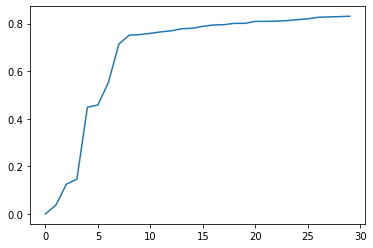

In [24]:
labels, distances = _p.knn_query(data[news_local_id], k = 30)
plt.plot(np.array(*distances))
dist_dict = {label:dist for label,dist in zip(*labels,*distances)}
dist_dict

In [25]:
#Сконкатим данные по векторам с данными по статьям
_dist =pd.DataFrame(*distances,index=[*labels],columns=['dist'])
_dist = _dist.reset_index(level=[0,0]).set_index('level_0')
_df = df[df.index.isin(_dist.index)]
dist = _dist.join(_df).sort_values(by=['dist'])

Попробовал посмотреть на каком месте новости по абсолютному вхождению заголовка

In [26]:
dist = dist.reset_index()
dist

,level_0,dist,id,name,create_date,category_id,text_orig,count_lemmas,header_duplicate,lemmas_join
0,33662,0.000000,17671792,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 11:48:01,81.0,"МОСКВА, 16 декабря. /ТАСС/. Эксперты ""Лаборато...",209,True,москв 16 декабр тасс эксперт лаборатор касперс...
1,34794,0.037042,17673019,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 12:02:17,81.0,"""Эксперты Kaspersky ICS CERT обнаружили вредон...",167,True,эксперт обнаруж вредоносн котор 20 январ 10 но...
2,49756,0.125108,17689437,Эксперты Kaspersky: вредоносное ПО PseudoManus...,2021-12-16 15:51:09,81.0,«Эксперты Kaspersky ICS CERT обнаружили вредон...,139,False,эксперт обнаруж вредоносн котор 20 январ 10 но...
3,47672,0.145957,17687166,"""Касперский"" обнаружил вирус, атаковавший тыся...",2021-12-16 15:13:54,81.0,"МОСКВА, 16 дек - ПРАЙМ. ""Лаборатория Касперско...",180,False,москв 16 дек прайм лаборатор касперск обнаруж ...
4,36846,0.448423,17675263,«Лаборатория Касперского» сообщила о 35 000 ки...,2021-12-16 12:29:30,81.0,"По словам специалистов, с 20 января по 10 нояб...",220,False,слов специалист 20 январ 10 ноябр 2021 г зафик...
5,48919,0.457797,17688526,"В ""Лаборатории Касперского"" рассказали о новом...",2021-12-16 15:35:20,81.0,"Как сообщается, атаки были совершены с помощью...",73,False,сообща атак соверш помощ программ котор получ ...
6,45854,0.552375,17685172,«Лаборатория Касперского» рассказала о новой ш...,2021-12-16 14:41:47,81.0,Основным целями для атак были государственные ...,207,False,основн цел атак государствен учрежден промышле...
7,4848,0.713984,17640080,"""ВидеоМатрикс"" и ""Ниеншанц-Автоматика"" протест...",2021-12-16 04:51:27,81.0,Тестирование выполнялось для проверки возможно...,402,False,тестирован выполня проверк возможн современ пр...
8,35316,0.751288,17673596,Отечественная селекционная работа в молочном ж...,2021-12-16 12:09:48,81.0,Параллельно с этим хозяйству необходимо не тол...,501,False,параллельн эт хозяйств необходим количествен п...
9,19104,0.753593,17655819,В России зафиксировали всплеск активности хаке...,2021-12-16 08:42:09,81.0,С момента обнаружения новой версии Emotet (был...,101,True,момент обнаружен нов верс найд израильск иссле...


### Совпадение косинусного расстояния и заголовка статьи

Если в поле ``header_duplicate`` все значения True, значит все ближайшие статьи имели заголовок, т.е. дубли

In [27]:
# посмотрим все новости которые пересекаются по заголовку

target_news = dist[dist['level_0']==news_local_id]['name'].iloc[0]
dist.query('name==@target_news')

,level_0,dist,id,name,create_date,category_id,text_orig,count_lemmas,header_duplicate,lemmas_join
0,33662,0.000000,17671792,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 11:48:01,81.0,"МОСКВА, 16 декабря. /ТАСС/. Эксперты ""Лаборато...",209,True,москв 16 декабр тасс эксперт лаборатор касперс...
1,34794,0.037042,17673019,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 12:02:17,81.0,"""Эксперты Kaspersky ICS CERT обнаружили вредон...",167,True,эксперт обнаруж вредоносн котор 20 январ 10 но...


Можно еще взять коэфициент = ``статьи с True/общее количество статей``. Он будет показывать, есть ли статьи с поменяным заголовком, но с таким же содержанием

### Последнее значение из дубликатов по заколовкам + 5*std

Берем  все дубликаты по заголовкам, упорядычиваем по косинусному расстоянию. Берем последний,самый нерелевантный, но совпадающий элемент. Это будет "ядро" точно похожих новостей, и потом в виде СКО мы разбавляем почти похожими (т.е. перепечатанными новостями)

In [28]:
last_index = dist.query('name==@target_news').index[-1]
std = dist.query('index <= @last_index')['dist'].std()
last_value = dist.query('name==@target_news')['dist'][-1:].iloc[0]
dist_threshold = last_value + 5*std
dist_threshold

0.16800344921648502

In [29]:
dist.query('dist <= @dist_threshold')

,level_0,dist,id,name,create_date,category_id,text_orig,count_lemmas,header_duplicate,lemmas_join
0,33662,0.000000,17671792,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 11:48:01,81.0,"МОСКВА, 16 декабря. /ТАСС/. Эксперты ""Лаборато...",209,True,москв 16 декабр тасс эксперт лаборатор касперс...
1,34794,0.037042,17673019,"""Лаборатория Касперского"" зафиксировала кибера...",2021-12-16 12:02:17,81.0,"""Эксперты Kaspersky ICS CERT обнаружили вредон...",167,True,эксперт обнаруж вредоносн котор 20 январ 10 но...
2,49756,0.125108,17689437,Эксперты Kaspersky: вредоносное ПО PseudoManus...,2021-12-16 15:51:09,81.0,«Эксперты Kaspersky ICS CERT обнаружили вредон...,139,False,эксперт обнаруж вредоносн котор 20 январ 10 но...
3,47672,0.145957,17687166,"""Касперский"" обнаружил вирус, атаковавший тыся...",2021-12-16 15:13:54,81.0,"МОСКВА, 16 дек - ПРАЙМ. ""Лаборатория Касперско...",180,False,москв 16 дек прайм лаборатор касперск обнаруж ...


### Покажем на каком уровне threshold

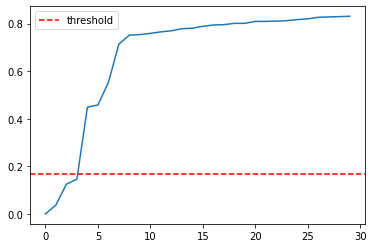

In [30]:
plt.plot(np.array(*distances));
plt.axhline(y=dist_threshold,c='red',ls='--',label='threshold')
plt.legend()
plt.plot;

### Список дублированных статей

In [31]:
dist.query('dist <= @dist_threshold')[['id','name']]

,id,name
0,17671792,"""Лаборатория Касперского"" зафиксировала кибера..."
1,17673019,"""Лаборатория Касперского"" зафиксировала кибера..."
2,17689437,Эксперты Kaspersky: вредоносное ПО PseudoManus...
3,17687166,"""Касперский"" обнаружил вирус, атаковавший тыся..."


## Кластеризация

In [32]:
from scipy.cluster.hierarchy import linkage, dendrogram

### Подготовим данные для кластеризации

In [33]:
#уберем вектор целевой статьи 
_dist = dist[1:]

In [34]:
# получим массив векторов по
knn_index = _dist['level_0'].values

In [35]:
# cопоставим вектор и их id
vec_indexes = df.index.isin(knn_index)
vec_dist = tf_idf.A[vec_indexes]

#тратсформируем в датафрэйм
vec_df = pd.DataFrame(vec_dist)
vec_df = pd.concat([vec_df,pd.DataFrame(knn_index)],axis=1,ignore_index=True)
vec_df = vec_df.rename(columns ={10000:'id_news'})

In [36]:
vec_dist

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Агломеративная кластеризация

Перед нами график иерархической кластеризации. Слева указаны кластера в которых расстояние между элементами и центром кластера самое маленькое.

>**Что мы хотели увидеть:**
 - В идеальном случае в левой части должны находится значения  близкие к нулю. 
 - В каждом кластере должны находиться значения близкие к друг другу, т.е. дисперсия должна быть минимальная
 - 2 кластера (в идеале)
 
>**Что мы увидели:**
 - слева находятся новости, далекие по расстоянию от рассматриваемой нововсте
 - нет близких значений в кластере, кроме кластера (оранжевый), но и в нем есть выброс -16 позиция
 - 4 кластера

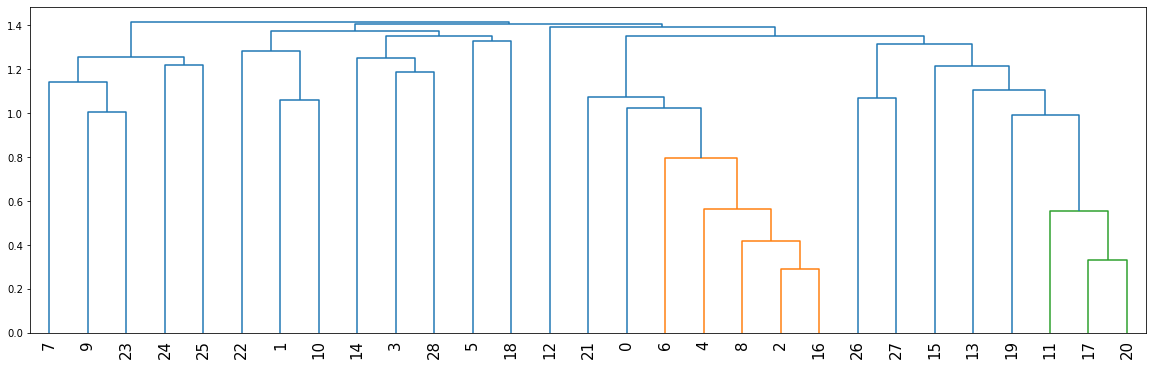

In [37]:
mergings = linkage(vec_dist, method='complete')

ax = plt.figure(figsize=(20,6))
dendrogram(mergings,
           labels=vec_df.index,
           leaf_rotation=90,
           leaf_font_size=15,
           distance_sort=True
           )
plt.show()


### T-SNE

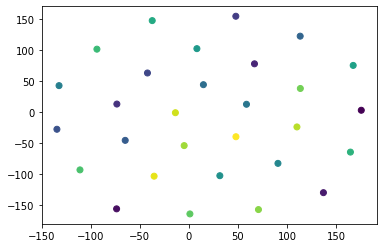

In [38]:
from sklearn.manifold import TSNE
# Определяем модель и скорость обучения
model = TSNE(learning_rate=200)
# Обучаем модель
transformed = model.fit_transform(vec_dist)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis, c=vec_df.index)
plt.show()

К сожалению мы сдесь не увидели результата, при представлениии обьектов в двумерном пространстве.

### DBSCAN

Метод не требует предварительных предположений о числе кластеров, но нужно настроить два других параметра: eps и min_samples. Данные параметры – это соответственно максимальное расстояние между соседними точками и минимальное число точек в окрестности (количество соседей), когда можно говорить, что эти экземпляры данных образуют один кластер.

Возьмем 2D пространство, т.к. данные проще отображать.

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [44]:
# Определяем модель
dbscan = DBSCAN()

# Обучаем
dbscan.fit(vec_dist)

# Уменьшаем размерность при помощи метода главных компонент. 
pca = PCA(n_components=2).fit(vec_dist)
pca_2d = pca.transform(vec_dist)
print('Уровень обьясняемой дисперсии в % :',sum(pca.explained_variance_ratio_))


Уровень обьясняемой дисперсии в % : 0.2571319883654406


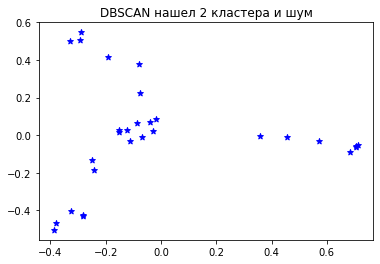

In [45]:
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
        
plt.title('DBSCAN нашел 2 кластера и шум')
plt.show()

In [46]:
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

К сожалению DBscan нашел только шумы

## Вывод <a id="5"></a>

Сформирован алгоритм, находящий полные дубли статей с необольшими девиациями(отклонениями). Путем вариации порога и дополнения статистик, мы можем настраивать выдачу алгоритма. 

Были опробованы алгоритмы кластеризации, но они дают нестабильный результат. В конце ииследования пришла идея создать эмбединг из времени создании файла и докинуть в вектор. Т.к. дубли статей как правило  находятся рядом друг с дргуом. 

В ходе исследования я начал склонятся к тому, что нужно более тщательно подойти к построению эмбедингов.

Из всего набора представленных данных найдено 14% дубликатов



### Потенциалы развития

- попробовать алгоритм на подмножествах данных, разные выборки
- уточнить у владельца продукта понятия "дублированная статья" и перенастроить алгоритм
- попробовать поиграться с количеством k-выдаваемых векторов и их статистиками
- посмотреть статистики по несовпадающим заголовками, прикрутить их в формулу расчета
- попробовать метод иерархической кластеризации для разделения k-векторов на дубли/не дубли
- поработать больше с БД, посмотреть метаданные новостей/источники данны
- попробовать учитывать время новости и давать больший вес новостям, когторые рядом. 
- пересмотреть подход к формированию эмбединогов. Данные подход достаточен для бэйзлайна, но не достаточен для продакшн.